<h1>Clustering of songs from two artist based on the lyrics</h1>

<h3>Import Libraries</h3>

In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from collections import Counter
import itertools
import os

<h3>Import visualisation libraries</h3>

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

<h3>Import libraries for natural language processing</h3>

In [3]:
import nltk
from nltk.stem import PorterStemmer
from nltk import pos_tag

<h3>Import libraries for clustering</h3>

In [4]:
from sklearn import feature_extraction
from sklearn.manifold import MDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.externals import joblib
from scipy.cluster.hierarchy import ward, dendrogram

<h3>Select PorterStemmer for stemming and create a corpus of english stop words</h3>

In [5]:
stemmer = PorterStemmer()
stopwords = nltk.corpus.stopwords.words('english')

<h3>Create function to remove line breaks (\n), lower the case of all words and remove stopwords</h3>

In [6]:
def clean_text(s):
    rem_sln = re.sub("[\n]", " ", s) 
    letters_only = re.sub("[^a-zA-Z]", " ", rem_sln) 
    words = letters_only.lower().split()       
    meaningful_words = [w for w in words if not w in stopwords]  
    return( " ".join( meaningful_words )) 

<h3>First tokenize by sentence, then by word to ensure that punctuation is caught as it's own token. Remove anything but letters and stem</h3>

In [7]:
def tokenize_stem(text, tostem=True):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    if tostem:
        stems = [stemmer.stem(t) for t in filtered_tokens]
        return stems
    else:
        return filtered_tokens

<h3>Read data into memory, filter by two artists, select columns, create list of artists column</h3>

In [8]:
df = pd.read_csv('songdata.csv')

df = df[df['artist'].isin(['Metallica', 'Lionel Richie'])][['artist', 'text']].reset_index()

#df = df[['artist', 'text']].reset_index()

artist_list = df['artist'].tolist()

#unique_artists = df['artist'].unique()

<h3>Apply clean_text function to each item in text column and add to clean_train list, creating a list of lyrics</h3>

In [9]:
num_reviews = df["text"].size
clean_train = []
for i in range( 0, num_reviews ):                                                                  
    clean_train.append( clean_text( df["text"][i] ))

<h3>Create a list of tokenized words and tokenized and stemmed words</h3>

In [10]:
totalvocab_stemmed = list(itertools.chain(*[tokenize_stem(i) for i in clean_train]))
totalvocab_tokenized = list(itertools.chain(*[tokenize_stem(i, tostem=False) for i in clean_train]))

<h3>Create dataframe from totalvocab_stemmed list as index and totalvocab_tokenized as only column</h3>

In [11]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 34037 items in vocab_frame


<h3>Apply sklearn's tfidf vectorizer, words must appear between 20% and 80% of songs, and will consider nglrms of length 1 to 3 words</h3>

In [12]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_stem, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(clean_train) 

terms = tfidf_vectorizer.get_feature_names()
dist = 1 - cosine_similarity(tfidf_matrix)

<h3>Apply kmeans algorithm for two clusters knowing there are two distinct artists</h3>

In [13]:
num_clusters = 2

km = KMeans(n_clusters=num_clusters)

km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

<h3>Create dataframe with cluster as index and title and cluster as columns</h3>

In [14]:
songs = { 'title': artist_list, 'synopsis': clean_train, 'cluster': clusters}

frame = pd.DataFrame(songs, index = [clusters] , columns = [ 'title', 'cluster'])

<h3>Display top occuring 7 words that define each cluster and a list of the songs, displaying just artist name, for each cluster</h3>

In [15]:
print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :7]: 
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0], end=',')
    print()
    print()
    
    print("Cluster %d titles:" % i, end='')
    for title in frame.loc[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print()
    print()

Top terms per cluster:

Cluster 0 words: love, heart, baby, oh, know, girl, want,

Cluster 0 titles: Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Lionel Richie, Metallica, Metallica, Metallica, Metallica, Metallica, Metallica, Metallica, Metallica, Metallica, Metallica, Metallica, Metallica, Metallica, Metall

<h3>Use multidimensional scaling to convert the 276 features into two dimensions for plotting using precomputed distance matrix</h3>

In [16]:
MDS()

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)

xs, ys = pos[:, 0], pos[:, 1]

<h3>Dictionaries for colours and names of clusters</h3>

In [17]:
cluster_colors = {0: '#1b9e77', 1: '#d95f02'}

cluster_names = {0: 'Cluster 0', 
                 1: 'Cluster 1'}

<h3>Create dataframe from the x and y coordinates from mds above, cluster number and artist name. Also a grouped by cluster dataframe</h3>

In [18]:
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=artist_list)) 

groups = df.groupby('label')

<h3>Plot each cluster seperately on the same chart for a visual representation of the clustering algorithm</h3>

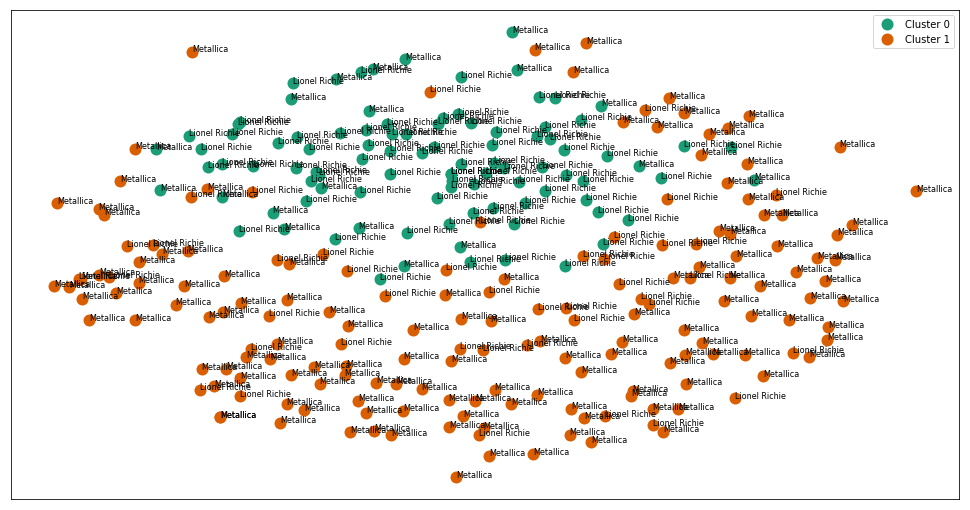

In [19]:
%matplotlib inline 

fig, ax = plt.subplots(figsize=(17, 9))
ax.margins(0.05)

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis= 'x',      
        which='both',  
        bottom=False,     
        top=False,        
        labelbottom=False)
    ax.tick_params(axis= 'y',        
        which='both',  
        left=False,    
        top=False,      
        labelleft=False)
    
ax.legend(numpoints=1) 

for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

plt.show()

<h3>Define the linkage_matrix using ward clustering pre-computed distances and plot dendrogam</h3>

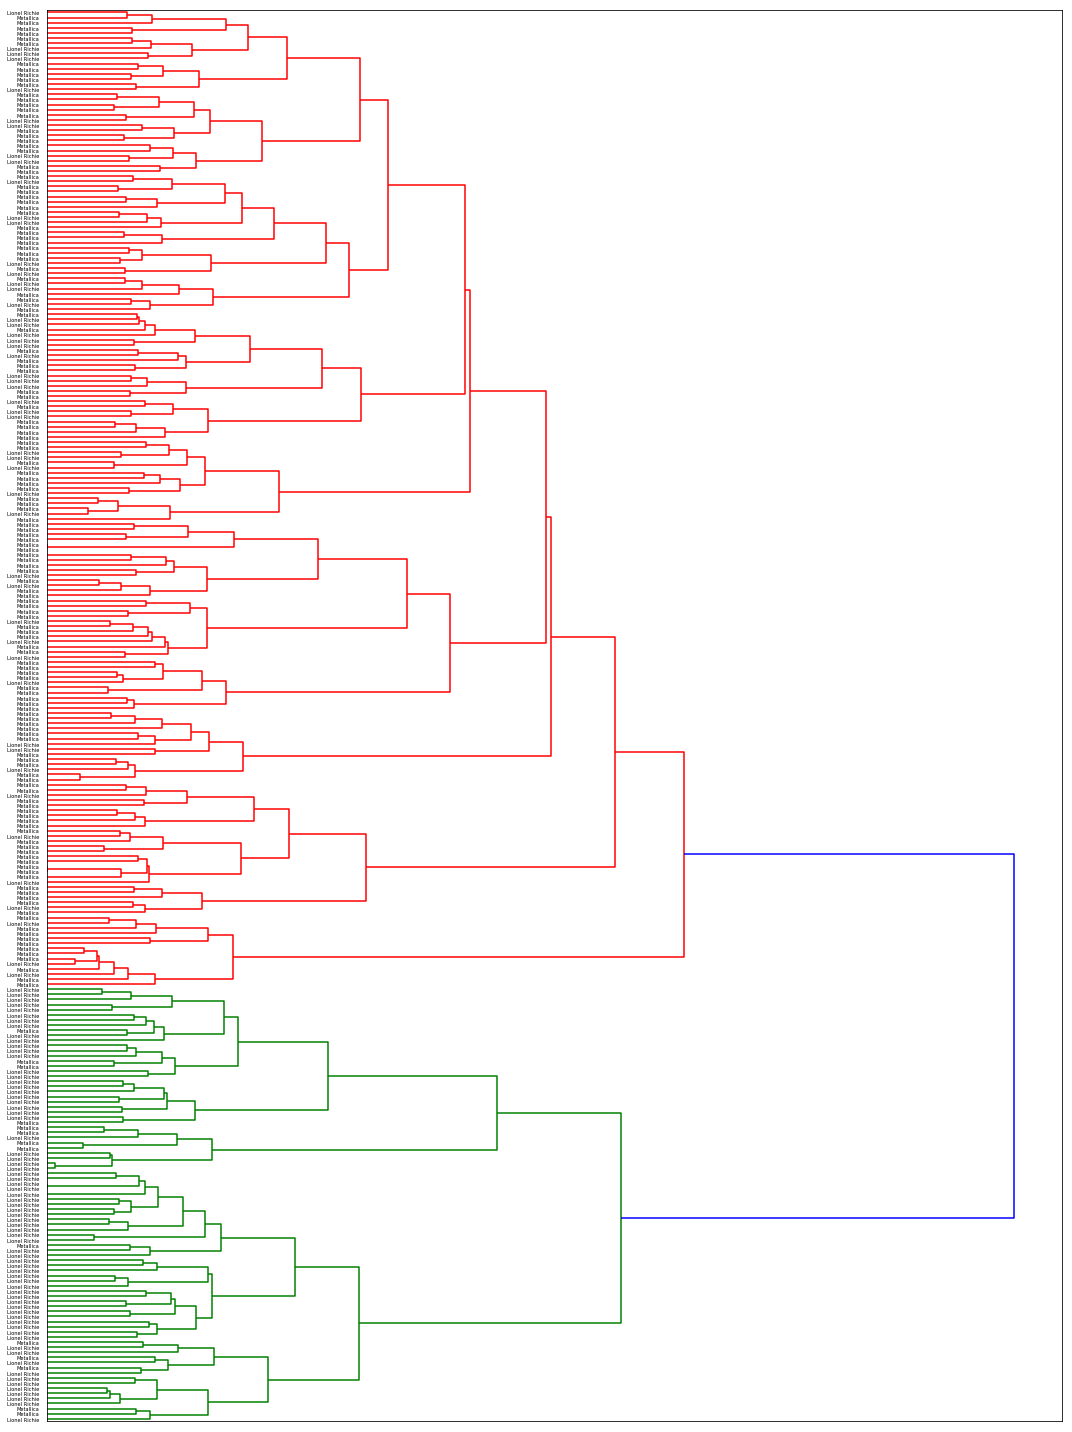

In [20]:
linkage_matrix = ward(dist)

fig, ax = plt.subplots(figsize=(15, 20))
ax = dendrogram(linkage_matrix, orientation="right", labels=artist_list);

plt.tick_params(axis= 'x',    
                which='both',     
                bottom=False, 
                top=False,       
                labelbottom=False)

plt.tight_layout() 